In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import glob

Download a content of TG channel manually.
If you have a Mac Pro, you can download a content from an app. 

In [3]:

text = []
for file in glob.glob("/Users/Oksana/Downloads/Telegram Desktop/ChatExport_2023-11-10/messages*.html"):
#for file in glob.glob("/Users/Oksana/Downloads/TELEGRAMS_CHATS_RU/ChatExport_2023-01-13 Росич | Rosich/messages*.html"):
    print(file)

    with open(file, 'r') as f:
        html = f.read()

    soup = BeautifulSoup(html, 'html.parser')

    time_parent = soup.find_all('div', class_='message default clearfix joined')

    for i in time_parent:
        time_t = i.find('div', class_='pull_right date details').text
        time_tt = i.find('div', class_='pull_right date details').get('title')

        if i.find('div', class_='text'):
            text_t = i.find('div', class_='text').text
        else:
            text_t = ''

        dict_d = {
            'time': time_t,
            'time_tt': time_tt,
            'text': text_t
        }

        text.append(dict_d)
    

/Users/Oksana/Downloads/Telegram Desktop/ChatExport_2023-11-10/messages48.html
/Users/Oksana/Downloads/Telegram Desktop/ChatExport_2023-11-10/messages33.html
/Users/Oksana/Downloads/Telegram Desktop/ChatExport_2023-11-10/messages25.html
/Users/Oksana/Downloads/Telegram Desktop/ChatExport_2023-11-10/messages13.html
/Users/Oksana/Downloads/Telegram Desktop/ChatExport_2023-11-10/messages44.html
/Users/Oksana/Downloads/Telegram Desktop/ChatExport_2023-11-10/messages2.html
/Users/Oksana/Downloads/Telegram Desktop/ChatExport_2023-11-10/messages29.html
/Users/Oksana/Downloads/Telegram Desktop/ChatExport_2023-11-10/messages28.html
/Users/Oksana/Downloads/Telegram Desktop/ChatExport_2023-11-10/messages3.html
/Users/Oksana/Downloads/Telegram Desktop/ChatExport_2023-11-10/messages45.html
/Users/Oksana/Downloads/Telegram Desktop/ChatExport_2023-11-10/messages12.html
/Users/Oksana/Downloads/Telegram Desktop/ChatExport_2023-11-10/messages24.html
/Users/Oksana/Downloads/Telegram Desktop/ChatExport_20

In [4]:
# Create a DataFrame from list of dicts

df = pd.DataFrame(text)
df.head(5)


,time,time_tt,text
0,\n19:27\n,13.10.2023 19:27:47 UTC+01:00,"\nМинздрав сектора Газа сообщил, что эвакуируе..."
1,\n22:26\n,13.10.2023 22:26:55 UTC+01:00,\nПолитическая кафедра западного университета ...
2,\n22:30\n,13.10.2023 22:30:34 UTC+01:00,\nА Мерседес не хочет уйти с Израильского рынк...
3,\n06:01\n,14.10.2023 06:01:25 UTC+01:00,\nНетаньяху: действия Израиля в секторе Газа —...
4,\n09:09\n,14.10.2023 09:09:06 UTC+01:00,


In [5]:
# split time_tt to date and time
df['date'] = df['time_tt'].str.split(' ').str[0]
df['time'] = df['time_tt'].str.split(' ').str[1]

# to datetime format from 12.07.2023 where 12 is a day, 07 is a month, 2023 is a year to 2023-07-12
df['date_tt'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

# remove \n from text
df['text'] = df['text'].str.replace('\n', '')

# Extract both month and year into one column
df['month_year'] = pd.to_datetime(df['date_tt']).dt.to_period('M')
df['month_year'] = df['month_year'].astype(str)
df.head(5)

,time,time_tt,text,date,date_tt,month_year
0,19:27:47,13.10.2023 19:27:47 UTC+01:00,"Минздрав сектора Газа сообщил, что эвакуирует ...",13.10.2023,2023-10-13,2023-10
1,22:26:55,13.10.2023 22:26:55 UTC+01:00,Политическая кафедра западного университета дв...,13.10.2023,2023-10-13,2023-10
2,22:30:34,13.10.2023 22:30:34 UTC+01:00,А Мерседес не хочет уйти с Израильского рынка?...,13.10.2023,2023-10-13,2023-10
3,06:01:25,14.10.2023 06:01:25 UTC+01:00,Нетаньяху: действия Израиля в секторе Газа — э...,14.10.2023,2023-10-14,2023-10
4,09:09:06,14.10.2023 09:09:06 UTC+01:00,,14.10.2023,2023-10-14,2023-10


<AxesSubplot:title={'center':'Number of media messages per month'}, xlabel='month_year'>

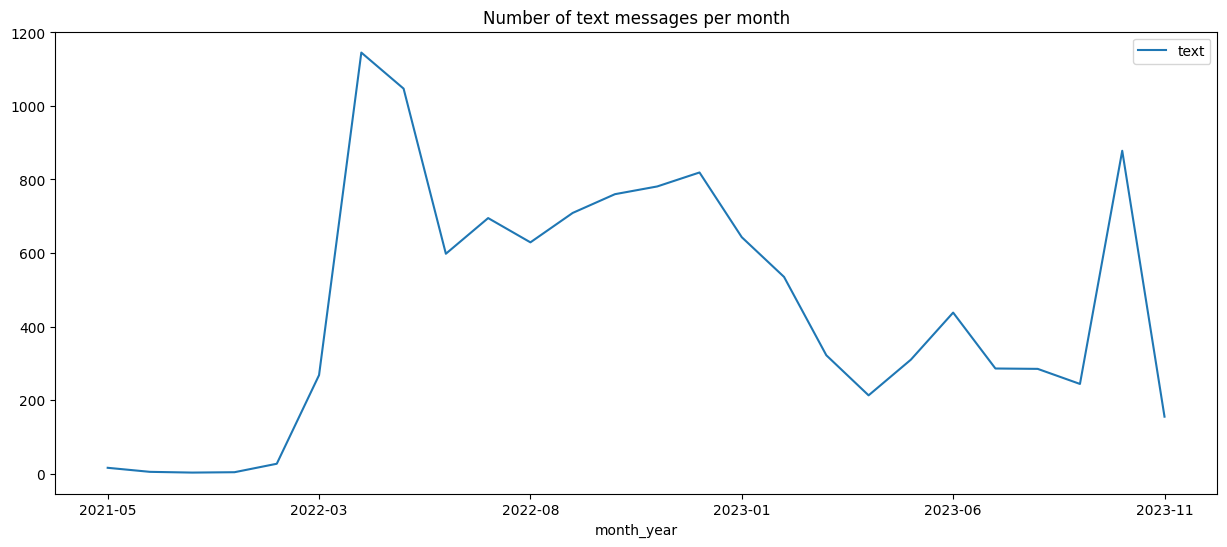

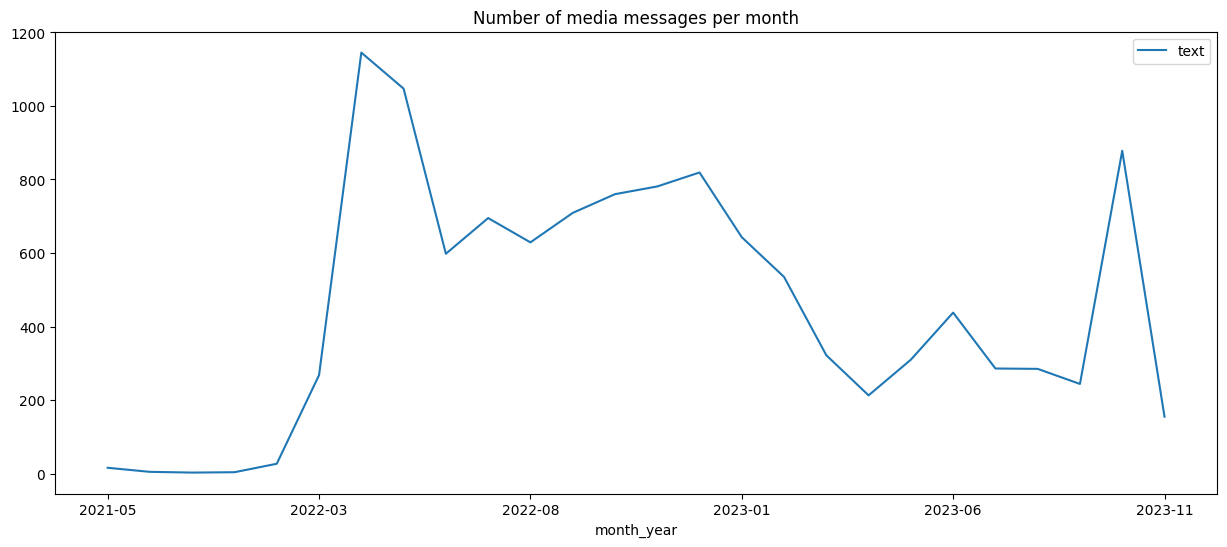

In [6]:
### TEXT ONLY in Messages ###
# filter where text is not empty
df_text = df[df['text'] != '']

# group by month and year and count number of messages
df_count_text = df_text.groupby('month_year')['text'].count()
df_count_text = df_count_text.reset_index()

# create a line plot, where x-axis is the month and year and y-axis is the number of messages
df_count_text.plot.line(x='month_year', y='text', figsize=(15, 6), title='Number of text messages per month')


### MEDIA CONTENT ###
# Empty text (only images, videos, etc.)
df_images = df[df['text'] == '']

# group by month and year and count number of messages
df_count_images = df_images.groupby('month_year')['text'].count()
df_count_images = df_count_images.reset_index()

# create a line plot, where x-axis is the month and year and y-axis is the number of messages
df_count_text.plot.line(x='month_year', y='text', figsize=(15, 6), title='Number of media messages per month')



In [7]:
### TEXT ANALYSIS ###

### NLTK libraries
import nltk
import ssl

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# https://www.youtube.com/watch?v=IBmZAYR0pns

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

#nltk.download('all')

In [8]:
# lower text
df_text_ta = df_text.copy()
df_text_ta['text'] = df_text_ta['text'].str.lower()

# Tokenize text
df_text_ta['text_tokens'] = df_text_ta['text'].apply(word_tokenize)
display(df_text_ta.head(4))

,time,time_tt,text,date,date_tt,month_year,text_tokens
0,19:27:47,13.10.2023 19:27:47 UTC+01:00,"минздрав сектора газа сообщил, что эвакуирует ...",13.10.2023,2023-10-13,2023-10,"[минздрав, сектора, газа, сообщил, ,, что, эва..."
1,22:26:55,13.10.2023 22:26:55 UTC+01:00,политическая кафедра западного университета дв...,13.10.2023,2023-10-13,2023-10,"[политическая, кафедра, западного, университет..."
2,22:30:34,13.10.2023 22:30:34 UTC+01:00,а мерседес не хочет уйти с израильского рынка?...,13.10.2023,2023-10-13,2023-10,"[а, мерседес, не, хочет, уйти, с, израильского..."
3,06:01:25,14.10.2023 06:01:25 UTC+01:00,нетаньяху: действия израиля в секторе газа — э...,14.10.2023,2023-10-14,2023-10,"[нетаньяху, :, действия, израиля, в, секторе, ..."


In [11]:
### Stopwords
from stopwords_emails_ru import stopwords_merged
print(len(stopwords_merged), type(stopwords_merged), stopwords_merged)
stopwords_merged = pd.DataFrame(stopwords_merged)
stopwords_merged

1617 <class 'list'> ['c', 'а', 'алло', 'без', 'белый', 'близко', 'более', 'больше', 'большой', 'будем', 'будет', 'будете', 'будешь', 'будто', 'буду', 'будут', 'будь', 'бы', 'бывает', 'бывь', 'был', 'была', 'были', 'было', 'быть', 'в', 'важная', 'важное', 'важные', 'важный', 'вам', 'вами', 'вас', 'ваш', 'ваша', 'ваше', 'ваши', 'вверх', 'вдали', 'вдруг', 'ведь', 'везде', 'вернуться', 'весь', 'вечер', 'взгляд', 'взять', 'вид', 'видел', 'видеть', 'вместе', 'вне', 'вниз', 'внизу', 'во', 'вода', 'война', 'вокруг', 'вон', 'вообще', 'вопрос', 'восемнадцатый', 'восемнадцать', 'восемь', 'восьмой', 'вот', 'впрочем', 'времени', 'время', 'все', 'все еще', 'всегда', 'всего', 'всем', 'всеми', 'всему', 'всех', 'всею', 'всю', 'всюду', 'вся', 'всё', 'второй', 'вы', 'выйти', 'г', 'где', 'главный', 'глаз', 'говорил', 'говорит', 'говорить', 'год', 'года', 'году', 'голова', 'голос', 'город', 'да', 'давать', 'давно', 'даже', 'далекий', 'далеко', 'дальше', 'даром', 'дать', 'два', 'двадцатый', 'двадцать', 'две

,0
0,c
1,а
2,алло
3,без
4,белый
...,...
1612,—
1613,%
1614,d0
1615,d1


In [12]:
df_text_ta['text_tokens_WO_stopwords'] = df_text_ta['text_tokens'].apply(lambda x: [item for item in x if item not in stopwords_merged.values])
display(df_text_ta.head(2))

# remove ' from text
df_text_ta['text_tokens_WO_stopwords'] = df_text_ta['text_tokens_WO_stopwords'].apply(lambda x: [item for item in x if item != "'"])
df_text_ta


,time,time_tt,text,date,date_tt,month_year,text_tokens,text_tokens_WO_stopwords
0,19:27:47,13.10.2023 19:27:47 UTC+01:00,"минздрав сектора газа сообщил, что эвакуирует ...",13.10.2023,2023-10-13,2023-10,"[минздрав, сектора, газа, сообщил, ,, что, эва...","[минздрав, сектора, газа, сообщил, эвакуирует,..."
1,22:26:55,13.10.2023 22:26:55 UTC+01:00,политическая кафедра западного университета дв...,13.10.2023,2023-10-13,2023-10,"[политическая, кафедра, западного, университет...","[политическая, кафедра, западного, университет..."


,time,time_tt,text,date,date_tt,month_year,text_tokens,text_tokens_WO_stopwords
0,19:27:47,13.10.2023 19:27:47 UTC+01:00,"минздрав сектора газа сообщил, что эвакуирует ...",13.10.2023,2023-10-13,2023-10,"[минздрав, сектора, газа, сообщил, ,, что, эва...","[минздрав, сектора, газа, сообщил, эвакуирует,..."
1,22:26:55,13.10.2023 22:26:55 UTC+01:00,политическая кафедра западного университета дв...,13.10.2023,2023-10-13,2023-10,"[политическая, кафедра, западного, университет...","[политическая, кафедра, западного, университет..."
2,22:30:34,13.10.2023 22:30:34 UTC+01:00,а мерседес не хочет уйти с израильского рынка?...,13.10.2023,2023-10-13,2023-10,"[а, мерседес, не, хочет, уйти, с, израильского...","[мерседес, хочет, уйти, израильского, рынка, а..."
3,06:01:25,14.10.2023 06:01:25 UTC+01:00,нетаньяху: действия израиля в секторе газа — э...,14.10.2023,2023-10-14,2023-10,"[нетаньяху, :, действия, израиля, в, секторе, ...","[нетаньяху, действия, израиля, секторе, газа, ..."
7,23:55:35,14.10.2023 23:55:35 UTC+01:00,иран направил израилю через оон предупреждающе...,14.10.2023,2023-10-14,2023-10,"[иран, направил, израилю, через, оон, предупре...","[иран, направил, израилю, оон, предупреждающее..."
...,...,...,...,...,...,...,...,...
26853,06:47:07,17.11.2022 06:47:07 UTC+01:00,"в харьковской, николаевской, днепропетровской ...",17.11.2022,2022-11-17,2022-11,"[в, харьковской, ,, николаевской, ,, днепропет...","[харьковской, николаевской, днепропетровской, ..."
26854,07:47:56,17.11.2022 07:47:56 UTC+01:00,тревога по всей территории 404@rosich_ru,17.11.2022,2022-11-17,2022-11,"[тревога, по, всей, территории, 404, @, rosich...","[тревога, всей, территории, 404, rosich_ru]"
26856,07:56:27,17.11.2022 07:56:27 UTC+01:00,днепропетровск! @rosich_ru,17.11.2022,2022-11-17,2022-11,"[днепропетровск, !, @, rosich_ru]","[днепропетровск, rosich_ru]"
26858,07:57:56,17.11.2022 07:57:56 UTC+01:00,"⚡️польша, ставьте сейчас пзрк на тракторы, укр...",17.11.2022,2022-11-17,2022-11,"[⚡️польша, ,, ставьте, сейчас, пзрк, на, тракт...","[⚡️польша, ставьте, пзрк, тракторы, украина, г..."


In [13]:
# Count the number of words in emails_grouped['bodyText_tokenized_filtered'] column
print("The dataframe with a new column where the number of words in a text is counted")

df_text_ta['count_words'] = df_text_ta['text_tokens_WO_stopwords'].apply(lambda x: len(x))
display(df_text_ta.head(1))

The dataframe with a new column where the number of words in a text is counted


,time,time_tt,text,date,date_tt,month_year,text_tokens,text_tokens_WO_stopwords,count_words
0,19:27:47,13.10.2023 19:27:47 UTC+01:00,"минздрав сектора газа сообщил, что эвакуирует ...",13.10.2023,2023-10-13,2023-10,"[минздрав, сектора, газа, сообщил, ,, что, эва...","[минздрав, сектора, газа, сообщил, эвакуирует,...",14


In [14]:
### Lemmatize words 
from collections import Counter

lemmatizer = WordNetLemmatizer()
df_text_ta['words_lemmatized'] = df_text_ta['text_tokens_WO_stopwords'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

print("\n" ,"The dataframe with a new column 'words_lemmatized_count' where the words are lemmatized and count")
df_text_ta['words_lemmatized_count'] = df_text_ta['words_lemmatized'].apply(lambda x: Counter(x))
display(df_text_ta.head(1))


 The dataframe with a new column 'words_lemmatized_count' where the words are lemmatized and count


,time,time_tt,text,date,date_tt,month_year,text_tokens,text_tokens_WO_stopwords,count_words,words_lemmatized,words_lemmatized_count
0,19:27:47,13.10.2023 19:27:47 UTC+01:00,"минздрав сектора газа сообщил, что эвакуирует ...",13.10.2023,2023-10-13,2023-10,"[минздрав, сектора, газа, сообщил, ,, что, эва...","[минздрав, сектора, газа, сообщил, эвакуирует,...",14,"[минздрав, сектора, газа, сообщил, эвакуирует,...","{'минздрав': 1, 'сектора': 1, 'газа': 1, 'сооб..."


In [15]:
# DF with most common words
df_lemma_mostCommon = df_text_ta.set_index('month_year').words_lemmatized_count.apply(pd.Series).stack().reset_index()

# an additional filter in level_1
df_lemma_mostCommon = df_lemma_mostCommon[df_lemma_mostCommon['level_1'] != '\'']
df_lemma_mostCommon = df_lemma_mostCommon[df_lemma_mostCommon['level_1'] != "''"]
df_lemma_mostCommon.to_csv('df_lemma_mostCommon.csv')

df_lemma_mostCommon.head(5)

/var/folders/gx/61q8sz7d4r9g0nl993whgmhc0000gp/T/ipykernel_71398/296146311.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_lemma_mostCommon = df_text_ta.set_index('month_year').words_lemmatized_count.apply(pd.Series).stack().reset_index()
/var/folders/gx/61q8sz7d4r9g0nl993whgmhc0000gp/T/ipykernel_71398/296146311.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_lemma_mostCommon = df_text_ta.set_index('month_year').words_lemmatized_count.apply(pd.Series).stack().reset_index()
/var/folders/gx/61q8sz7d4r9g0nl993whgmhc0000gp/T/ipykernel_71398/296146311.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_lemma_mostCommon = df_text_

,month_year,level_1,0
0,2023-10,минздрав,1.0
1,2023-10,сектора,1.0
2,2023-10,газа,1.0
3,2023-10,сообщил,1.0
4,2023-10,эвакуирует,1.0


In [16]:
### REGEX for crypto in order to find crypto addresses in text. Not a full list of crypto addresses, but the most popular

crypto_bitcoin = "BTC:\s(bc1[a-zA-Z0-9]{25,41})"
crypto_bitcoin_cash = "BCH:\s(q|p)[a-zA-Z0-9]{41}"
crypto_bitcoin2 = "BTC:\s(bc1[a-zA-Z0-9]{25,41})"
 
crypto_ethereum = "0x[a-fA-F0-9]{40}$" # ru
crypto_litecoin = "^[LM3][a-km-zA-HJ-NP-Z1-9]{26,33}$"
crypto_dash = "^X[1-9A-HJ-NP-Za-km-z]{33}$" # ru
crypto_ripple = "^r[0-9a-zA-Z]{24,34}$"
crypto_monero = "^4[0-9AB][1-9A-HJ-NP-Za-km-z]{93}$"
crypto_nem = "^N[A-Z0-9]{33}$"
crypto_neo = "^A[0-9a-zA-Z]{33}$"
crypto_iota = "^9[A-Z]{27}$"
crypto_zcash = "^t1[a-zA-Z0-9]{33}$"
crypto_dogecoin = "^[DQ][1-9A-HJ-NP-Za-km-z]{33,34}$"
crypto_binance = "^bnb1[a-z0-9]{38}$"
crypto_cardano = "^addr1[0-9a-zA-Z]{58}$"
crypto_tether = "^1[0-9A-Za-z]{33}$"
crypto_stellar = "^G[A-Z0-9]{55}$"
crypto_tron = "^T[0-9a-zA-Z]{33}$" # ru 
crypto_eos = "^EOS[0-9a-zA-Z]{40}$"


# Find crypto crypto_bitcoin in text

"""
Not the most efficient way to find crypto addresses in text, but it works.
"""

df['crypto_bitcoin'] = df['text'].str.findall(crypto_bitcoin)
df['crypto_bitcoin_cash'] = df['text'].str.findall(crypto_bitcoin_cash)
df['crypto_bitcoin2'] = df['text'].str.findall(crypto_bitcoin2)


df['crypto_ethereum'] = df['text'].str.findall(crypto_ethereum)
df['crypto_litecoin'] = df['text'].str.findall(crypto_litecoin)
df['crypto_dash'] = df['text'].str.findall(crypto_dash)
df['crypto_ripple'] = df['text'].str.findall(crypto_ripple)
df['crypto_monero'] = df['text'].str.findall(crypto_monero)
df['crypto_nem'] = df['text'].str.findall(crypto_nem)
df['crypto_neo'] = df['text'].str.findall(crypto_neo)
df['crypto_iota'] = df['text'].str.findall(crypto_iota)
df['crypto_zcash'] = df['text'].str.findall(crypto_zcash)
df['crypto_dogecoin'] = df['text'].str.findall(crypto_dogecoin)
df['crypto_binance'] = df['text'].str.findall(crypto_binance)
df['crypto_cardano'] = df['text'].str.findall(crypto_cardano)
df['crypto_tether'] = df['text'].str.findall(crypto_tether)
df['crypto_stellar'] = df['text'].str.findall(crypto_stellar)
df['crypto_tron'] = df['text'].str.findall(crypto_tron)
df['crypto_eos'] = df['text'].str.findall(crypto_eos)

In [17]:
### PREPARE DATA ###
# make a copy of the dataframe
df_copy = df.copy()

# a columb to look for credit card numbers
df_copy['credit_card'] = df_copy['text'].str.findall(r'\b\d{4} \d{4} \d{4} \d{4}\b')

# combine columns with crypto into one column
df_copy['crypto'] = df_copy['crypto_bitcoin'] + df_copy['crypto_bitcoin_cash'] + df_copy['crypto_bitcoin2'] + df_copy['crypto_ethereum'] + df_copy['crypto_litecoin'] + df_copy['crypto_dash'] + df_copy['crypto_ripple'] + df_copy['crypto_monero'] + df_copy['crypto_nem'] + df_copy['crypto_neo'] + df_copy['crypto_iota'] + df_copy['crypto_zcash'] + df_copy['crypto_dogecoin'] + df_copy['crypto_binance'] + df_copy['crypto_cardano'] + df_copy['crypto_tether'] + df_copy['crypto_stellar'] + df_copy['crypto_tron'] + df_copy['crypto_eos']

# deselect crypto columns
df_copy = df_copy.drop(columns=['crypto_bitcoin', 'crypto_bitcoin_cash', 'crypto_bitcoin2', 'crypto_ethereum', 'crypto_litecoin', 'crypto_dash', 'crypto_ripple', 'crypto_monero', 'crypto_nem', 'crypto_neo', 'crypto_iota', 'crypto_zcash', 'crypto_dogecoin', 'crypto_binance', 'crypto_cardano', 'crypto_tether', 'crypto_stellar', 'crypto_tron', 'crypto_eos'])


### CRYPTO WALLET ADDRESSES ###
# Filter by an empty crypto column
df_crypto = df_copy[df_copy['crypto'].map(len) > 0]

# split crypto values by rows. One row - one crypto address
df_crypto = df_crypto.explode('crypto')
df_crypto.to_csv('chat_cryptoWallets.csv', index=False, encoding='utf-8', sep=';') 
df_crypto.head(5)

### BANK ACCOUNTS ###
# split credit card values by rows
df_banks = df_copy.drop(columns=['crypto']) 
df_banks = df_banks[df_banks['credit_card'].map(len) > 0]
df_banks = df_banks.explode('credit_card')

# remove white spaces from credit card numbers
df_banks['credit_card'] = df_banks['credit_card'].str.replace(' ', '')
df_banks.to_csv('chat_bankAccounts.csv', index=False, encoding='utf-8', sep=';')
df_banks.head(5)


,time,time_tt,text,date,date_tt,month_year,credit_card
1221,22:51:17,28.10.2022 22:51:17 UTC+01:00,❗️СБОР❗️Военнослужащим армейского спецназа тре...,28.10.2022,2022-10-28,2022-10,5469400045355711
1728,23:33:44,21.06.2022 23:33:44 UTC+01:00,❗️СБОР РОСИЧИ❗️Для успешной работы наших спецо...,21.06.2022,2022-06-21,2022-06,2200150545522499
1728,23:33:44,21.06.2022 23:33:44 UTC+01:00,❗️СБОР РОСИЧИ❗️Для успешной работы наших спецо...,21.06.2022,2022-06-21,2022-06,5469400045355711
3424,15:28:52,10.12.2022 15:28:52 UTC+01:00,"❗️На данный момент собрано 153.000₽, остаётся ...",10.12.2022,2022-12-10,2022-12,2202202312834736
3436,22:04:01,10.12.2022 22:04:01 UTC+01:00,"❗️На данный момент собрано 188.000₽, остаётся ...",10.12.2022,2022-12-10,2022-12,5469400045355711
